# This is an experiment working on COVID-19
1. differential equation
2. parametric estimation
3. load data from url
4. filtering using julia DataFrames

# Matematical model
## The SIR model without vital dynamics

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

The dynamics of an epidemic, for example the flu, are often much faster than the dynamics of birth and death, therefore, birth and death are often omitted in simple compartmental models. The SIR system without so-called vital dynamics (birth and death, sometimes called demography) described above can be expressed by the following set of ordinary differential equations:

1.
$$\frac{dS}{dt} = -\frac{\beta IS}{N} $$

2.
$$\frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I$$

3.
$$\frac{dR}{dt} = \gamma I$$

where:

1.
$$\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$$

2.
$$S(t) + I(t) + R(t) = N$$

## POC

This is a Proof Of Concept. We follows these step:
1. start from syntetic data
2. set differential equations
3. set parameter with fake data
4. solve equation
5. sample the output variables
6. setup for regression paramater esitmation
7. execute estimation
8. compare the estimated parameter with fake ones

In [1]:
using DifferentialEquations
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim, LinearAlgebra
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

N = 1000

# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
f = @ode_def sir_model begin
    dS = -β*S*I/N
    dI = β*S*I/N - γ*I
    dR = γ*I
end β γ

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273


(::sir_model{var"###ParameterizedDiffEqFunction#445",var"###ParameterizedTGradFunction#446",var"###ParameterizedJacobianFunction#447",Nothing,Nothing,ModelingToolkit.ODESystem}) (generic function with 1 method)

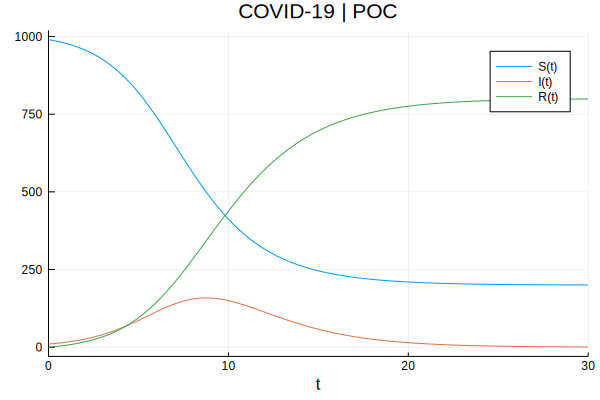

In [4]:
p = [1.0, 0.5]
u0 = [N-10; 10; 0.0]; tspan = (0.0, 30.0)
prob = ODEProblem(f, u0, tspan, p);
# Solve the problem
sol = solve(prob, Tsit5(), reltol=1e-9, abstol=1e-9);
dt = .1 # step: number of day
tf = 100.0
tinterval = 0:dt:tf
t  = collect(tinterval)

using Plots; gr() # Using the Plotly Backend
sol = solve(prob, Tsit5(), saveat=t, reltol=1e-9, abstol=1e-9)
p2 = plot(sol, title="COVID-19 | POC")

In [5]:
data = convert(Array, sol)

loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 10), (0, 10),]
loc_init = [1,0.5]
glo_init = [5,5]

using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim, LinearAlgebra
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

obj = build_loss_objective(prob, Tsit5(), L2Loss(t, data), tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 1e4);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.52 secs, 2012 evals, 1883 steps, improv/step: 0.224 (last = 0.2236), fitness=23051.080489739
1.02 secs, 4193 evals, 4064 steps, improv/step: 0.241 (last = 0.2563), fitness=0.003777968
1.53 secs, 6418 evals, 6289 steps, improv/step: 0.242 (last = 0.2427), fitness=0.000000045
2.03 secs, 8491 evals, 8363 steps, improv/step: 0.242 (last = 0.2425), fitness=0.000000000

Optimization stopped after 10001 steps and 2.40 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 4168.82
Function evals per second = 4221.76
Improvements/step = 0.24050
Total function evaluations = 10128


Best candidate found: [1.0, 0.5]

Fitness: 0.000000000



## Result

Fitness: 0.000000000

This is a good result parameter estimation fit the provided data

## Load data from: Dipartimento della Protezione Civile
https://github.com/pcm-dpc/COVID-19

In [6]:
using HTTP
using DataFrames
using CSV

# get public data
# Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile
# https://github.com/pcm-dpc/COVID-19
res = HTTP.get("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
df = CSV.read(res.body);

In [7]:
# filter relevant data
lombardia = filter(row -> row[:codice_regione] == 3, df)
filtered = lombardia[:, [:totale_casi, :dimessi_guariti, :deceduti]];

In [26]:
# putting all together

# polulation
N = 10e6
# infected
I = transpose(filtered[!, 1])
I = 10.0 .* I
# death
d = transpose(filtered[!, 2])
# recovered
g = transpose(filtered[!, 3])
# I = I + d ./ 0.01
# recovered+death
R = d .+ g
# susceptible population
S = N .- I

data = vcat(S, I, R)
tinterval = 1:1:size(S)[2]
t = collect(tinterval);

In [27]:
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

N = 10e6 # population

f = @ode_def sir_model begin
    dS = -β*S*I/N
    dI = β*S*I/N - γ*I
    dR = γ*I
end β γ

(::sir_model{var"###ParameterizedDiffEqFunction#497",var"###ParameterizedTGradFunction#498",var"###ParameterizedJacobianFunction#499",Nothing,Nothing,ModelingToolkit.ODESystem}) (generic function with 1 method)

In [28]:
C = I[1] # init value infected population
# N-C -> init value susceptible population

p = [1, 1]
u0 = [N-C; C; 0.0]; tspan = (0.0, 50.0)
prob = ODEProblem(f, u0, tspan, p);

In [29]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 1), (0, 1),]
loc_init = [1, 0.5]
glo_init = [5, 5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 1e5);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 13451 steps and 0.38 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 35028.66
Function evals per second = 32268.24
Improvements/step = 0.01729
Total function evaluations = 12391


Best candidate found: [0.191415, 0.00706108]

Fitness: 44611587809.034866333



## Result
Fitness: 294533216.648505211

Which is not good at all

## Using the estimated parameters

In [30]:
p = [0.191415, 0.00706108]
u0 = [N-C; C; 0.0]; tspan = (0.0, 100.0)
prob = ODEProblem(f, u0, tspan, p);

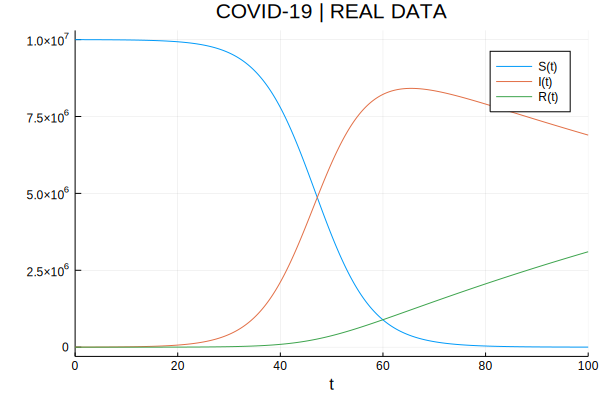

In [31]:
using Plots; gr() # Using the Plotly Backend
sol = solve(prob, Tsit5(), reltol=1e-9, abstol=1e-9)
p2 = plot(sol, title="COVID-19 | REAL DATA")

# Happy end?
Hope this work is wrong

In [12]:
I

1×28 Array{Float64,2}:
 172.0  240.0  258.0  4403.0  4531.0  4615.0  …  451764.0  530515.0  613706.0